In [1]:
#####################################################################
#                   example 5 (DEPRECATED)                          #
#    In this script we demonstrate how to use QuSpin's to build     #
#    the Hamiltonian of the SSH model in real and momentum space.   #
#    Along the way, we showcase the block tools which allow the     #
#    user to create block-diagonal Hamiltonians. Last, we show      #
#    how to time-evolve free fermion states like the Fermi sea      #
#    and measure correlators.                                       #
#####################################################################
from quspin.operators import hamiltonian, exp_op  # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d  # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian  # block diagonalisation
import numpy as np  # generic math functions
import matplotlib.pyplot as plt  # plotting library

try:  # import python 3 zip function in python 2 and pass if already using python 3
    import itertools.izip as zip
except ImportError:
    pass
##### define model parameters #####
L = 50  # system size
J = 1.0  # uniform hopping
deltaJ = -0.1  # bond dimerisation
Delta = 0  # staggered potential, keep Delta = 0 
beta = 100.0  # inverse temperature for Fermi-Dirac distribution
##### construct single-particle Hamiltonian #####
# define site-coupling lists
hop_pm = [[-J - deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L-1)]  # OBC
hop_mp = [[+J + deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L-1)]  # OBC
stagg_pot = [[Delta * (-1) ** i, i] for i in range(L)]
# define static and dynamic lists
static = [["+-", hop_pm], ["-+", hop_mp], ["n", stagg_pot]]
dynamic = []
# define basis
basis = spinless_fermion_basis_1d(L, Nf=1)
# build real-space Hamiltonian
H = hamiltonian(static, dynamic, basis=basis, dtype=np.float64)
# diagonalise real-space Hamiltonian
E, V = H.eigh()
##### compute Fourier transform and momentum-space Hamiltonian #####
# define momentm blocks and basis arguments
blocks = [
    dict(Nf=1, kblock=i, a=2) for i in range(L // 2)
]  # only L//2 distinct momenta
basis_args = (L,)
# construct block-diagonal Hamiltonian
FT, Hblock = block_diag_hamiltonian(
    blocks,
    static,
    dynamic,
    spinless_fermion_basis_1d,
    basis_args,
    np.complex128,
    get_proj_kwargs=dict(pcon=True),
)
# diagonalise momentum-space Hamiltonian
Eblock, Vblock = Hblock.eigh()
##### prepare the density observables and initial states #####
# grab single-particle states and treat them as initial states
psi0 = Vblock
# construct operator n_1 = $n_{j=0}$
n_1_static = [["n", [[1.0, 0]]]]
n_1 = hamiltonian(
    n_1_static, [], basis=basis, dtype=np.float64, check_herm=False, check_pcon=False
)
# construct operator n_2 = $n_{j=L/2}$
n_2_static = [["n", [[1.0, L // 2]]]]
n_2 = hamiltonian(
    n_2_static, [], basis=basis, dtype=np.float64, check_herm=False, check_pcon=False
)
# transform n_j operators to momentum space
n_1 = n_1.rotate_by(FT, generator=False)
n_2 = n_2.rotate_by(FT, generator=False)
##### evaluate nonequal time correlator <FS|n_2(t) n_1(0)|FS> #####
# define time vector
t = np.linspace(0.0, 90.0, 901)
# calcualte state acted on by n_1
n_psi0 = n_1.dot(psi0)
# construct time-evolution operator using exp_op class (sometimes faster)
U = exp_op(Hblock, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=True)
# evolve states
psi_t = U.dot(psi0)
n_psi_t = U.dot(n_psi0)
# alternative method for time evolution using Hamiltonian class
# psi_t=Hblock.evolve(psi0,0.0,t,iterate=True)
# n_psi_t=Hblock.evolve(n_psi0,0.0,t,iterate=True)
# preallocate variable
correlators = np.zeros(t.shape + psi0.shape[1:])
# loop over the time-evolved states
for i, (psi, n_psi) in enumerate(zip(psi_t, n_psi_t)):
    correlators[i, :] = n_2.matrix_ele(psi, n_psi, diagonal=True).real
# evaluate correlator at finite temperature
n_FD = 1.0 / (np.exp(beta * E) + 1.0)
correlator = (n_FD * correlators).sum(axis=-1)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


/var/folders/35/9ww2n_n554s25_5x1fsr8s700000gn/T/ipykernel_48227/2776980792.py:47: UserWarning: The following static operator strings do not obey T symm: ['-+', '+-']
  FT, Hblock = block_diag_hamiltonian(


Hermiticity check passed!


TypeError: Hamiltonian does not obey T symm! To turn off check, use check_symm=False in hamiltonian.

NameError: name 'Hblock' is not defined

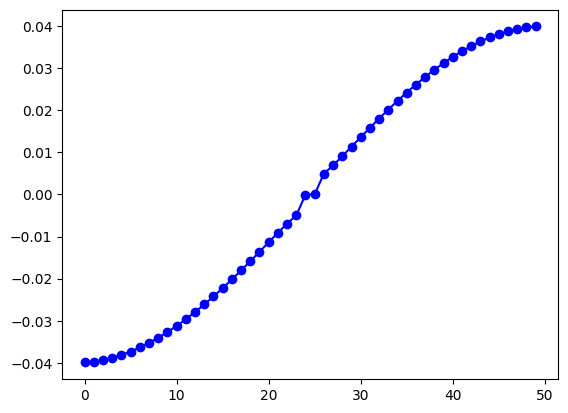

In [5]:
##### plot spectra
plt.plot(np.arange(H.Ns), E / L, marker="o", color="b", label="real space")
plt.plot(
    np.arange(Hblock.Ns),
    Eblock / L,
    marker="x",
    color="r",
    markersize=2,
    label="momentum space",
)
plt.xlabel("state number", fontsize=16)
plt.ylabel("energy", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("example5a.pdf", bbox_inches="tight")
# plt.show()
plt.close()
##### plot correlator
plt.plot(t, correlator, linewidth=2)
plt.xlabel("$t$", fontsize=16)
plt.ylabel("$C_{0,L/2}(t,\\beta)$", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("example5b.pdf", bbox_inches="tight")
# plt.show()
plt.close()

In [206]:
def n_expectation_per_site(N, Np, J, U, V, delta, sps):
    from quspin.operators import hamiltonian
    from quspin.basis import boson_basis_1d
    import numpy as np

    basis = boson_basis_1d(N, Nb=Np, sps=sps)

    # Liste di termini per l'Hamiltoniana
    hopping = [[-J + (-1)**i * delta, i, (i + 1) % N] for i in range(N-1)]
    int_bb = [[0.5 * U, j, j] for j in range(N)]
    int_b = [[-0.5 * U, j] for j in range(N)]

    static = [
        ["+-", hopping],
        ["-+", hopping],
        ["n", int_b],
        ["nn", int_bb],
    ]

    H = hamiltonian(static, [], basis=basis, dtype=np.float64)

    # Calcolo del ground state
    E0, psi0 = H.eigsh(k=1, which="SA")
    psi0 = psi0[:, 0]

    # Calcolo di ⟨n_i⟩ su ogni sito
    n_vals = np.array([
        np.vdot(psi0, hamiltonian([["n", [[1.0, i]]]], [], basis=basis).dot(psi0)).real
        for i in range(N)
    ])

    return n_vals

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Part

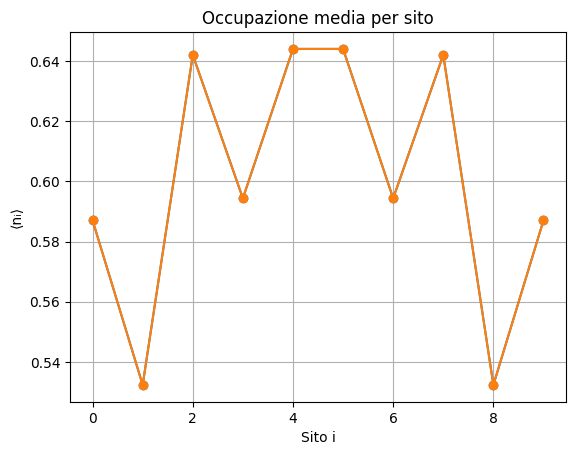

In [212]:
n_vals = n_expectation_per_site(N=10, Np=6, J=1, U=100, V=0, delta=-0.3, sps=5)
n_vals_del = n_expectation_per_site(N=10, Np=6, J=1, U=100, V=0, delta=0.3, sps=5)
print("⟨n_i⟩ =", n_vals)

import matplotlib.pyplot as plt
plt.plot(range(len(n_vals)), n_vals, marker='o')
plt.plot(range(len(n_vals_del)), n_vals, marker='o')
plt.xlabel("Sito i")
plt.ylabel("⟨nᵢ⟩")
plt.title("Occupazione media per sito")
plt.grid(True)
#plt.ylim([0,1])
plt.show()

n_vals = [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Shape: (10,)
